In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Requirements
```
python==3.8.5
tensorflow==2.4.0
keras==2.4.3
numpy==1.21.4
pandas==1.3.5
sklearn==0.24.2
matplotlib==3.3.2
tqdm==4.41.1
pyrsgis==0.4.1
```

In [ ]:
!pip install pyrsgis

In [ ]:
# import the necessary packages
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from tifffile import imread
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import os
import cv2
import tensorflow as tf
import datetime

### 1) Load Dataset

In [ ]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
folder_path = list(paths.list_images('/content/drive/My Drive/dataset/data_fix'))
data = []
labels = []
# loop over the image paths
for folder_path in tqdm(folder_path, desc = "importing images"):
	# extract the class label from the filename
	label = folder_path.split(os.path.sep)[-2]
	# load the input image and preprocess it
	image = imread(folder_path)
	image = cv2.resize(image, (5, 5))
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data)
labels = np.array(labels) # 0=Hutan, 1=Lahan Kosong, 2=Lahan Terbangun, 3=Perkebunan, and 4=Sawah
np.unique(labels)

importing images:   0%|          | 0/1000 [00:00<?, ?it/s]

array(['hutan', 'lahan_kosong', 'lahan_terbangun', 'perkebunan', 'sawah'],
      dtype='<U15')

### 2) Split Dataset

In [ ]:
# perform one-hot encoding on the labels
enc = LabelEncoder().fit(labels)
encoded_labels = enc.transform(labels)
# Transpose the features to "float32" format
data_features = np.array(data, dtype="float32")

# partition the data into training and testing splits using 80%:20%
(trainX, testX, trainY, testY) = train_test_split(data_features, encoded_labels, test_size=0.30, stratify=encoded_labels, random_state=42)

In [ ]:
# summarize loaded dataset
print('Train set: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Test set: X=%s, y=%s' % (testX.shape, testY.shape))

# Find the unique numbers from the train labels
classes = np.unique(trainY)
nClasses = len(classes)
print('Output classes : ', classes)
print('Total number of outputs : ', nClasses)

Train set: X=(700, 5, 5, 4), y=(700,)
Test set: X=(300, 5, 5, 4), y=(300,)
Output classes :  [0 1 2 3 4]
Total number of outputs :  5


### 3) Plot Data

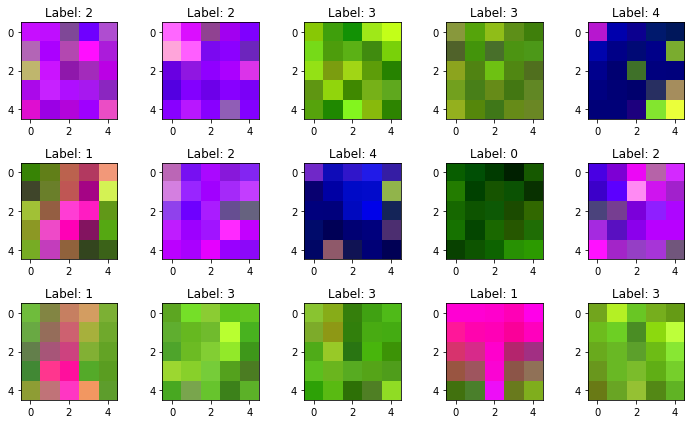

In [ ]:
# plot first few images
num_row = 3
num_col = 5 # plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col,2*num_row))
for i in range(15):
	# define subplot
	ax = axes[i//num_col, i%num_col]
	# plot raw pixel data
	ax.imshow(trainX[i].astype('uint8'))
	ax.set_title("Label: {}".format(trainY[i]))
# show the figure
plt.tight_layout()
plt.show()

### 4) Normalize Data

In [ ]:
# normalize to range 0-1
trainX_norm = trainX / 255
testX_norm = testX / 255

# Change the labels from integer to one hot encoding data (perform one-hot encoding on the labels)
trainY_one_hot = to_categorical(trainY)
testY_one_hot = to_categorical(testY)


print('Original label 0 : ', trainY[0])
print('After conversion to categorical ( one-hot ) : ', trainY_one_hot[0])

Original label 0 :  2
After conversion to categorical ( one-hot ) :  [0. 0. 1. 0. 0.]


In [ ]:
# Define the Model
nRows, nCols, nchannels = trainX_norm.shape[1:]
input_shape = (nRows, nCols, nchannels)

def createModel():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=1, padding='valid', activation='relu', input_shape=input_shape))
    model.add(Dropout(0.25))

    model.add(Conv2D(48, kernel_size=1, padding='valid', activation='relu'))
    model.add(Dropout(0.25))

    model.add(Conv2D(48, kernel_size=1, padding='valid', activation='relu'))
    model.add(Dropout(0.25))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))   
    return model

### 6) Model Configuration

In [ ]:
# Configure the Model
model_cnn = createModel()
model_cnn.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 5, 5, 32)          160       
                                                                 
 dropout (Dropout)           (None, 5, 5, 32)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 48)          1584      
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 48)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 48)          2352      
                                                                 
 dropout_2 (Dropout)         (None, 5, 5, 48)          0         
                                                                 
 flatten (Flatten)           (None, 1200)              0

### 7) Fit CNN Model

In [ ]:
from numpy.random import seed
seed(222)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history_cnn = model_cnn.fit(trainX_norm, trainY_one_hot, batch_size=32, epochs=15, verbose=1, 
                            validation_data=(testX_norm, testY_one_hot), callbacks=[tensorboard_callback])

Epoch 1/15
22/22 [==============================] - 1s 16ms/step - loss: 1.4014 - accuracy: 0.4157 - val_loss: 0.9336 - val_accuracy: 0.6833
Epoch 2/15
22/22 [==============================] - 0s 7ms/step - loss: 0.7783 - accuracy: 0.7357 - val_loss: 0.4333 - val_accuracy: 0.8467
Epoch 3/15
22/22 [==============================] - 0s 7ms/step - loss: 0.4069 - accuracy: 0.8471 - val_loss: 0.2122 - val_accuracy: 0.9233
Epoch 4/15
22/22 [==============================] - 0s 7ms/step - loss: 0.2474 - accuracy: 0.9243 - val_loss: 0.0831 - val_accuracy: 0.9800
Epoch 5/15
22/22 [==============================] - 0s 7ms/step - loss: 0.1829 - accuracy: 0.9457 - val_loss: 0.0829 - val_accuracy: 0.9633
Epoch 6/15
22/22 [==============================] - 0s 8ms/step - loss: 0.1474 - accuracy: 0.9514 - val_loss: 0.0353 - val_accuracy: 0.9933
Epoch 7/15
22/22 [==============================] - 0s 8ms/step - loss: 0.1245 - accuracy: 0.9557 - val_loss: 0.0554 - val_accuracy: 0.9733
Epoch 8/15
22/22 [=

### 8) Evaluate the Model

In [ ]:
# Evaluate the Trained Model
[test_loss, test_acc] = model_cnn.evaluate(testX_norm, testY_one_hot)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

10/10 [==============================] - 0s 2ms/step - loss: 0.0268 - accuracy: 0.9800
Evaluation result on Test Data : Loss = 0.026797190308570862, accuracy = 0.9800000190734863


In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score, accuracy_score

# Predict the most likely class
test_predict_class = np.argmax(model_cnn.predict(testX_norm), axis=-1)

# calculate measurement
cMatrix = confusion_matrix(testY, test_predict_class)
acScore = accuracy_score(testY, test_predict_class)
kappaScore = cohen_kappa_score(testY, test_predict_class)

print("Confusion matrix:\n", cMatrix)
print("\n Accuracy-Score: %.3f and Kappa-Score: %.3f" % (acScore, kappaScore))

Confusion matrix:
 [[57  0  0  3  0]
 [ 0 57  2  1  0]
 [ 0  0 60  0  0]
 [ 0  0  0 60  0]
 [ 0  0  0  0 60]]

 Accuracy-Score: 0.980 and Kappa-Score: 0.975


### 9) Save the Model

In [ ]:
# Save the model inside a folder to use later
if not os.path.exists(os.path.join(os.getcwd(), '/content/drive/My Drive/dataset/model/')):
    os.mkdir(os.path.join(os.getcwd(), '/content/drive/My Drive/dataset/model/'))
    
model_cnn.save('/content/drive/My Drive/dataset/model/CNN_Model.h5') 

### 10) Load the Model & Prediction

In [ ]:
!pip install pyrsgis

In [ ]:
# necessary packages
from pyrsgis import raster, ml
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/content/drive/My Drive/dataset/model/CNN_Model.h5')

#### - Prediksi DAS Bengkulu Tahun 2000

In [ ]:
# Load a new multispectral image
ds, imagas = raster.read('/content/drive/My Drive/dataset/das_bengkulu/2000.tif')
new_features = ml.array_to_chips(imagas, y_size=5, x_size=5)

print('Shape of the images', imagas.shape)
print('Shape of the new features', new_features.shape)

Shape of the images (4, 582, 768)
Shape of the new features (446976, 5, 5, 4)


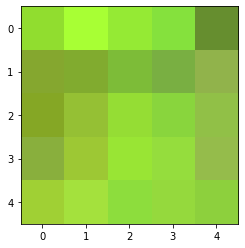

In [ ]:
plt.imshow(new_features[332000])

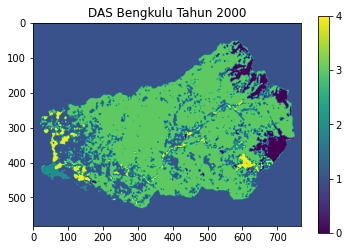

In [ ]:
# Predict new data and export the probability raster
newPredicted = model.predict(new_features/255)
Predicted = np.argmax(newPredicted, axis=-1)
prediction = np.reshape(Predicted, (ds.RasterYSize, ds.RasterXSize))

# Plotting
fig, ax = plt.subplots()
h = ax.imshow(prediction, vmin = 0, vmax = 4)
fig.colorbar(h, ticks = np.linspace(0,4,5))
ax.set_title(f'DAS Bengkulu Tahun 2000')
fig.show()

In [ ]:
# Count the number of pixels 
unique, counts = np.unique(prediction, return_counts=True)
dict(zip(unique, counts))

{0: 15460, 1: 270111, 2: 5744, 3: 146974, 4: 8687}

In [ ]:
#save as.tif
output_file = r'/content/drive/MyDrive/dataset/output/2000.tif'
raster.export(prediction, ds, output_file, dtype='float32')

#### - Prediksi DAS Bengkulu Tahun 2001

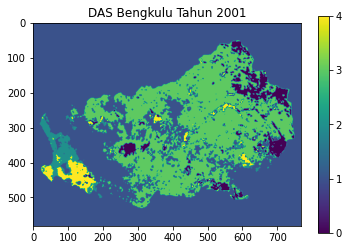

In [ ]:
# Load a new multispectral image
ds, imagas = raster.read('/content/drive/My Drive/dataset/das_bengkulu/2001.tif')
new_features = ml.array_to_chips(imagas, y_size=5, x_size=5)

# Predict new data and export the probability raster
newPredicted = model.predict(new_features/255)
Predicted = np.argmax(newPredicted, axis=-1)
prediction = np.reshape(Predicted, (ds.RasterYSize, ds.RasterXSize))

# Plotting
fig, ax = plt.subplots()
h = ax.imshow(prediction, vmin = 0, vmax = 4)
fig.colorbar(h, ticks = np.linspace(0,4,5))
ax.set_title(f'DAS Bengkulu Tahun 2001')
fig.show()

In [ ]:
# Count the number of pixels 
unique, counts = np.unique(prediction, return_counts=True)
dict(zip(unique, counts))

{0: 19949, 1: 291115, 2: 9162, 3: 117672, 4: 9078}

In [ ]:
#save as.tif
output_file = r'/content/drive/MyDrive/dataset/output/2001.tif'
raster.export(prediction, ds, output_file, dtype='float32')

#### - Prediksi DAS Bengkulu Tahun 2002

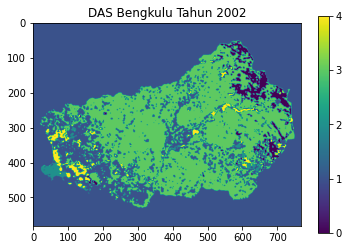

In [ ]:
# Load a new multispectral image
ds, imagas = raster.read('/content/drive/My Drive/dataset/das_bengkulu/2002.tif')
new_features = ml.array_to_chips(imagas, y_size=5, x_size=5)

# Predict new data and export the probability raster
newPredicted = model.predict(new_features/255)
Predicted = np.argmax(newPredicted, axis=-1)
prediction = np.reshape(Predicted, (ds.RasterYSize, ds.RasterXSize))

# Plotting
fig, ax = plt.subplots()
h = ax.imshow(prediction, vmin = 0, vmax = 4)
fig.colorbar(h, ticks = np.linspace(0,4,5))
ax.set_title(f'DAS Bengkulu Tahun 2002')
fig.show()

In [ ]:
# Count the number of pixels 
unique, counts = np.unique(prediction, return_counts=True)
dict(zip(unique, counts))

{0: 14253, 1: 278385, 2: 5860, 3: 140215, 4: 8263}

In [ ]:
#save as.tif
output_file = r'/content/drive/MyDrive/dataset/output/2002.tif'
raster.export(prediction, ds, output_file, dtype='float32')

#### - Prediksi DAS Bengkulu Tahun 2003

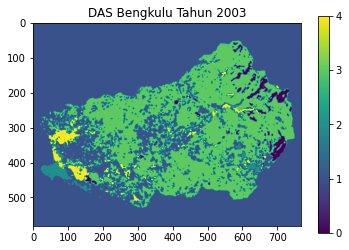

In [ ]:
# Load a new multispectral image
ds, imagas = raster.read('/content/drive/My Drive/dataset/das_bengkulu/2003.tif')
new_features = ml.array_to_chips(imagas, y_size=5, x_size=5)

# Predict new data and export the probability raster
newPredicted = model.predict(new_features/255)
Predicted = np.argmax(newPredicted, axis=-1)
prediction = np.reshape(Predicted, (ds.RasterYSize, ds.RasterXSize))

# Plotting
fig, ax = plt.subplots()
h = ax.imshow(prediction, vmin = 0, vmax = 4)
fig.colorbar(h, ticks = np.linspace(0,4,5))
ax.set_title(f'DAS Bengkulu Tahun 2003')
fig.show()

In [ ]:
# Count the number of pixels 
unique, counts = np.unique(prediction, return_counts=True)
dict(zip(unique, counts))

{0: 9224, 1: 287062, 2: 8440, 3: 133209, 4: 9041}

In [ ]:
#save as.tif
output_file = r'/content/drive/MyDrive/dataset/output/2003.tif'
raster.export(prediction, ds, output_file, dtype='float32')

#### - Prediksi DAS Bengkulu Tahun 2004

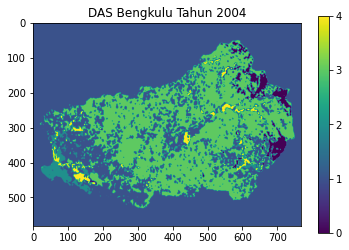

In [ ]:
# Load a new multispectral image
ds, imagas = raster.read('/content/drive/My Drive/dataset/das_bengkulu/2004.tif')
new_features = ml.array_to_chips(imagas, y_size=5, x_size=5)

# Predict new data and export the probability raster
newPredicted = model.predict(new_features/255)
Predicted = np.argmax(newPredicted, axis=-1)
prediction = np.reshape(Predicted, (ds.RasterYSize, ds.RasterXSize))

# Plotting
fig, ax = plt.subplots()
h = ax.imshow(prediction, vmin = 0, vmax = 4)
fig.colorbar(h, ticks = np.linspace(0,4,5))
ax.set_title(f'DAS Bengkulu Tahun 2004')
fig.show()

In [ ]:
# Count the number of pixels 
unique, counts = np.unique(prediction, return_counts=True)
dict(zip(unique, counts))

{0: 13615, 1: 308408, 2: 12563, 3: 106007, 4: 6383}

In [ ]:
#save as.tif
output_file = r'/content/drive/MyDrive/dataset/output/2004.tif'
raster.export(prediction, ds, output_file, dtype='float32')

#### - Prediksi DAS Bengkulu Tahun 2005

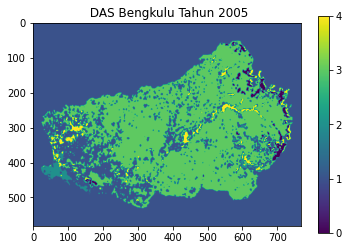

In [ ]:
# Load a new multispectral image
ds, imagas = raster.read('/content/drive/My Drive/dataset/das_bengkulu/2005.tif')
new_features = ml.array_to_chips(imagas, y_size=5, x_size=5)

# Predict new data and export the probability raster
newPredicted = model.predict(new_features/255)
Predicted = np.argmax(newPredicted, axis=-1)
prediction = np.reshape(Predicted, (ds.RasterYSize, ds.RasterXSize))

# Plotting
fig, ax = plt.subplots()
h = ax.imshow(prediction, vmin = 0, vmax = 4)
fig.colorbar(h, ticks = np.linspace(0,4,5))
ax.set_title(f' DAS Bengkulu Tahun 2005')
fig.show()

In [ ]:
# Count the number of pixels 
unique, counts = np.unique(prediction, return_counts=True)
dict(zip(unique, counts))

{0: 8210, 1: 290410, 2: 7135, 3: 133307, 4: 7914}

In [ ]:
#save as.tif
output_file = r'/content/drive/MyDrive/dataset/output/2005.tif'
raster.export(prediction, ds, output_file, dtype='float32')

#### - Prediksi DAS Bengkulu Tahun 2006

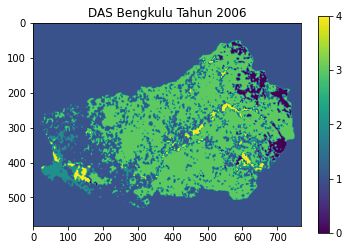

In [ ]:
# Load a new multispectral image
ds, imagas = raster.read('/content/drive/My Drive/dataset/das_bengkulu/2006.tif')
new_features = ml.array_to_chips(imagas, y_size=5, x_size=5)

# Predict new data and export the probability raster
newPredicted = model.predict(new_features/255)
Predicted = np.argmax(newPredicted, axis=-1)
prediction = np.reshape(Predicted, (ds.RasterYSize, ds.RasterXSize))

# Plotting
fig, ax = plt.subplots()
h = ax.imshow(prediction, vmin = 0, vmax = 4)
fig.colorbar(h, ticks = np.linspace(0,4,5))
ax.set_title(f'DAS Bengkulu Tahun 2006')
fig.show()

In [ ]:
# Count the number of pixels 
unique, counts = np.unique(prediction, return_counts=True)
dict(zip(unique, counts))

{0: 12810, 1: 291278, 2: 9797, 3: 126051, 4: 7040}

In [ ]:
#save as.tif
output_file = r'/content/drive/MyDrive/dataset/output/2006.tif'
raster.export(prediction, ds, output_file, dtype='float32')

#### - Prediksi DAS Bengkulu Tahun 2007

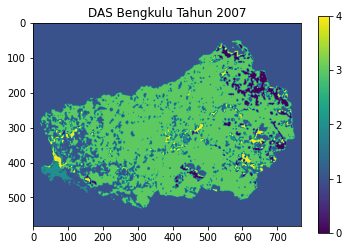

In [ ]:
# Load a new multispectral image
ds, imagas = raster.read('/content/drive/My Drive/dataset/das_bengkulu/2007.tif')
new_features = ml.array_to_chips(imagas, y_size=5, x_size=5)

# Predict new data and export the probability raster
newPredicted = model.predict(new_features/255)
Predicted = np.argmax(newPredicted, axis=-1)
prediction = np.reshape(Predicted, (ds.RasterYSize, ds.RasterXSize))

# Plotting
fig, ax = plt.subplots()
h = ax.imshow(prediction, vmin = 0, vmax = 4)
fig.colorbar(h, ticks = np.linspace(0,4,5))
ax.set_title(f'DAS Bengkulu Tahun 2007')
fig.show()

In [ ]:
# Count the number of pixels 
unique, counts = np.unique(prediction, return_counts=True)
dict(zip(unique, counts))

{0: 14395, 1: 267455, 2: 4869, 3: 152221, 4: 8036}

In [ ]:
#save as.tif
output_file = r'/content/drive/MyDrive/dataset/output/2007.tif'
raster.export(prediction, ds, output_file, dtype='float32')

#### - Prediksi DAS Bengkulu Tahun 2008

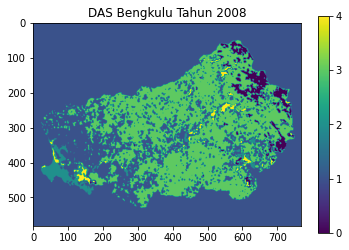

In [ ]:
# Load a new multispectral image
ds, imagas = raster.read('/content/drive/My Drive/dataset/das_bengkulu/2008.tif')
new_features = ml.array_to_chips(imagas, y_size=5, x_size=5)

# Predict new data and export the probability raster
newPredicted = model.predict(new_features/255)
Predicted = np.argmax(newPredicted, axis=-1)
prediction = np.reshape(Predicted, (ds.RasterYSize, ds.RasterXSize))

# Plotting
fig, ax = plt.subplots()
h = ax.imshow(prediction, vmin = 0, vmax = 4)
fig.colorbar(h, ticks = np.linspace(0,4,5))
ax.set_title(f'DAS Bengkulu Tahun 2008')
fig.show()

In [ ]:
# Count the number of pixels 
unique, counts = np.unique(prediction, return_counts=True)
dict(zip(unique, counts))

{0: 13005, 1: 296390, 2: 8831, 3: 123744, 4: 5006}

In [ ]:
#save as.tif
output_file = r'/content/drive/MyDrive/dataset/output/2008.tif'
raster.export(prediction, ds, output_file, dtype='float32')

#### - Prediksi DAS Bengkulu Tahun 2009

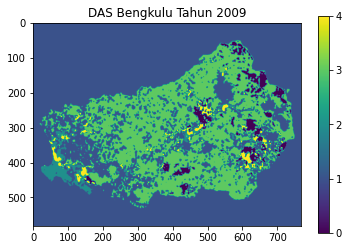

In [ ]:
# Load a new multispectral image
ds, imagas = raster.read('/content/drive/My Drive/dataset/das_bengkulu/2009.tif')
new_features = ml.array_to_chips(imagas, y_size=5, x_size=5)

# Predict new data and export the probability raster
newPredicted = model.predict(new_features/255)
Predicted = np.argmax(newPredicted, axis=-1)
prediction = np.reshape(Predicted, (ds.RasterYSize, ds.RasterXSize))

# Plotting
fig, ax = plt.subplots()
h = ax.imshow(prediction, vmin = 0, vmax = 4)
fig.colorbar(h, ticks = np.linspace(0,4,5))
ax.set_title(f'DAS Bengkulu Tahun 2009')
fig.show()

In [ ]:
# Count the number of pixels 
unique, counts = np.unique(prediction, return_counts=True)
dict(zip(unique, counts))

{0: 14705, 1: 291206, 2: 9451, 3: 123808, 4: 7806}

In [ ]:
#save as.tif
output_file = r'/content/drive/MyDrive/dataset/output/2009.tif'
raster.export(prediction, ds, output_file, dtype='float32')

#### - Prediksi DAS Bengkulu Tahun 2010

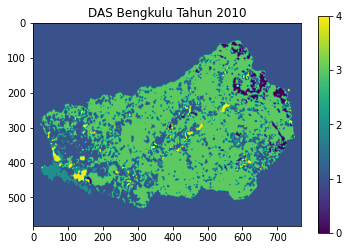

In [ ]:
# Load a new multispectral image
ds, imagas = raster.read('/content/drive/My Drive/dataset/das_bengkulu/2010.tif')
new_features = ml.array_to_chips(imagas, y_size=5, x_size=5)

# Predict new data and export the probability raster
newPredicted = model.predict(new_features/255)
Predicted = np.argmax(newPredicted, axis=-1)
prediction = np.reshape(Predicted, (ds.RasterYSize, ds.RasterXSize))

# Plotting
fig, ax = plt.subplots()
h = ax.imshow(prediction, vmin = 0, vmax = 4)
fig.colorbar(h, ticks = np.linspace(0,4,5))
ax.set_title(f'DAS Bengkulu Tahun 2010')
fig.show()

In [ ]:
# Count the number of pixels 
unique, counts = np.unique(prediction, return_counts=True)
dict(zip(unique, counts))

{0: 9859, 1: 282688, 2: 7804, 3: 139990, 4: 6635}

In [ ]:
#save as.tif
output_file = r'/content/drive/MyDrive/dataset/output/2010.tif'
raster.export(prediction, ds, output_file, dtype='float32')

#### - Prediksi DAS Bengkulu Tahun 2011

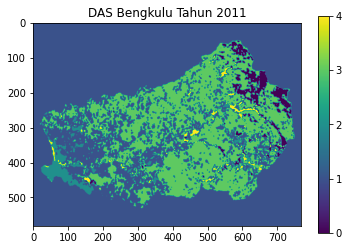

In [ ]:
# Load a new multispectral image
ds, imagas = raster.read('/content/drive/My Drive/dataset/das_bengkulu/2011.tif')
new_features = ml.array_to_chips(imagas, y_size=5, x_size=5)

# Predict new data and export the probability raster
newPredicted = model.predict(new_features/255)
Predicted = np.argmax(newPredicted, axis=-1)
prediction = np.reshape(Predicted, (ds.RasterYSize, ds.RasterXSize))

# Plotting
fig, ax = plt.subplots()
h = ax.imshow(prediction, vmin = 0, vmax = 4)
fig.colorbar(h, ticks = np.linspace(0,4,5))
ax.set_title(f'DAS Bengkulu Tahun 2011')
fig.show()

In [ ]:
# Count the number of pixels 
unique, counts = np.unique(prediction, return_counts=True)
dict(zip(unique, counts))

{0: 14572, 1: 297124, 2: 10247, 3: 119968, 4: 5065}

In [ ]:
#save as.tif
output_file = r'/content/drive/MyDrive/dataset/output/2011.tif'
raster.export(prediction, ds, output_file, dtype='float32')

#### - Prediksi DAS Bengkulu Tahun 2012

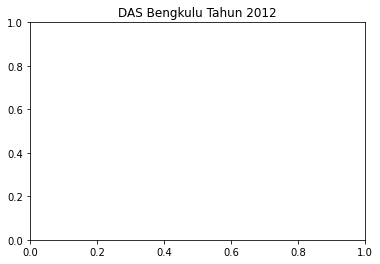

In [ ]:
# Load a new multispectral image
ds, imagas = raster.read('/content/drive/My Drive/dataset/das_bengkulu/2012.tif')
new_features = ml.array_to_chips(imagas, y_size=5, x_size=5)

# Predict new data and export the probability raster
newPredicted = model.predict(new_features/255)
Predicted = np.argmax(newPredicted, axis=-1)
prediction = np.reshape(Predicted, (ds.RasterYSize, ds.RasterXSize))

# Plotting
fig, ax = plt.subplots()
#h = ax.imshow(prediction, vmin = 0, vmax = 4)
#fig.colorbar(h, ticks = np.linspace(0,4,5))
ax.set_title(f'DAS Bengkulu Tahun 2012')
fig.show()

In [ ]:
# Count the number of pixels 
unique, counts = np.unique(prediction, return_counts=True)
dict(zip(unique, counts))

{0: 14292, 1: 282237, 2: 9953, 3: 135209, 4: 5285}

In [ ]:
#save as.tif
output_file = r'/content/drive/MyDrive/dataset/output/2012.tif'
raster.export(prediction, ds, output_file, dtype='float32')

NameError: ignored

#### - Prediksi DAS Bengkulu Tahun 2013

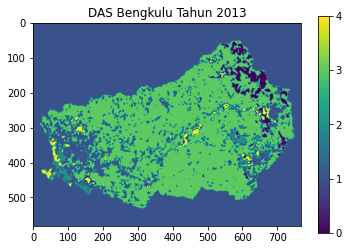

In [ ]:
# Load a new multispectral image
ds, imagas = raster.read('/content/drive/My Drive/dataset/das_bengkulu/2013.tif')
new_features = ml.array_to_chips(imagas, y_size=5, x_size=5)

# Predict new data and export the probability raster
newPredicted = model.predict(new_features/255)
Predicted = np.argmax(newPredicted, axis=-1)
prediction = np.reshape(Predicted, (ds.RasterYSize, ds.RasterXSize))

# Plotting
fig, ax = plt.subplots()
h = ax.imshow(prediction, vmin = 0, vmax = 4)
fig.colorbar(h, ticks = np.linspace(0,4,5))
ax.set_title(f'DAS Bengkulu Tahun 2013')
fig.show()

In [ ]:
# Count the number of pixels 
unique, counts = np.unique(prediction, return_counts=True)
dict(zip(unique, counts))

{0: 12209, 1: 269064, 2: 6516, 3: 152740, 4: 6447}

In [ ]:
#save as.tif
output_file = r'/content/drive/MyDrive/dataset/output/2013.tif'
raster.export(prediction, ds, output_file, dtype='float32')

#### - Prediksi DAS Bengkulu Tahun 2014

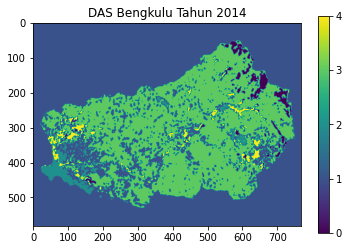

In [ ]:
# Load a new multispectral image
ds, imagas = raster.read('/content/drive/My Drive/dataset/das_bengkulu/2014.tif')
new_features = ml.array_to_chips(imagas, y_size=5, x_size=5)

# Predict new data and export the probability raster
newPredicted = model.predict(new_features/255)
Predicted = np.argmax(newPredicted, axis=-1)
prediction = np.reshape(Predicted, (ds.RasterYSize, ds.RasterXSize))

# Plotting
fig, ax = plt.subplots()
h = ax.imshow(prediction, vmin = 0, vmax = 4)
fig.colorbar(h, ticks = np.linspace(0,4,5))
ax.set_title(f'DAS Bengkulu Tahun 2014')
fig.show()

In [ ]:
# Count the number of pixels 
unique, counts = np.unique(prediction, return_counts=True)
dict(zip(unique, counts))

{0: 9547, 1: 271033, 2: 10187, 3: 148506, 4: 7703}

In [ ]:
#save as.tif
output_file = r'/content/drive/MyDrive/dataset/output/2014.tif'
raster.export(prediction, ds, output_file, dtype='float32')

#### - Prediksi DAS Bengkulu Tahun 2015

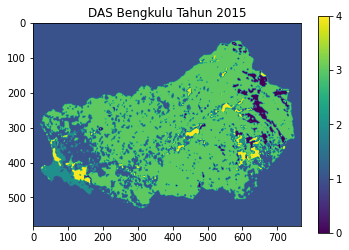

In [ ]:
# Load a new multispectral image
ds, imagas = raster.read('/content/drive/My Drive/dataset/das_bengkulu/2015.tif')
new_features = ml.array_to_chips(imagas, y_size=5, x_size=5)

# Predict new data and export the probability raster
newPredicted = model.predict(new_features/255)
Predicted = np.argmax(newPredicted, axis=-1)
prediction = np.reshape(Predicted, (ds.RasterYSize, ds.RasterXSize))

# Plotting
fig, ax = plt.subplots()
h = ax.imshow(prediction, vmin = 0, vmax = 4)
fig.colorbar(h, ticks = np.linspace(0,4,5))
ax.set_title(f'DAS Bengkulu Tahun 2015')
fig.show()

In [ ]:
# Count the number of pixels 
unique, counts = np.unique(prediction, return_counts=True)
dict(zip(unique, counts))

{0: 10750, 1: 267237, 2: 8866, 3: 152018, 4: 8105}

In [ ]:
#save as.tif
output_file = r'/content/drive/MyDrive/dataset/output/2015.tif'
raster.export(prediction, ds, output_file, dtype='float32')

#### - Prediksi DAS Bengkulu Tahun 2016

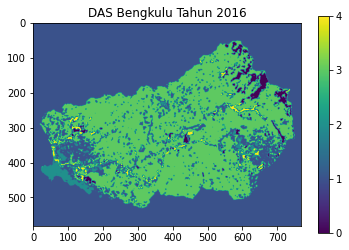

In [ ]:
# Load a new multispectral image
ds, imagas = raster.read('/content/drive/My Drive/dataset/das_bengkulu/2016.tif')
new_features = ml.array_to_chips(imagas, y_size=5, x_size=5)

# Predict new data and export the probability raster
newPredicted = model.predict(new_features/255)
Predicted = np.argmax(newPredicted, axis=-1)
prediction = np.reshape(Predicted, (ds.RasterYSize, ds.RasterXSize))

# Plotting
fig, ax = plt.subplots()
h = ax.imshow(prediction, vmin = 0, vmax = 4)
fig.colorbar(h, ticks = np.linspace(0,4,5))
ax.set_title(f'DAS Bengkulu Tahun 2016')
fig.show()

In [ ]:
# Count the number of pixels 
unique, counts = np.unique(prediction, return_counts=True)
dict(zip(unique, counts))

{0: 11604, 1: 263650, 2: 8347, 3: 157714, 4: 5661}

In [ ]:
#save as.tif
output_file = r'/content/drive/MyDrive/dataset/output/2016.tif'
raster.export(prediction, ds, output_file, dtype='float32')

#### - Prediksi DAS Bengkulu Tahun 2017

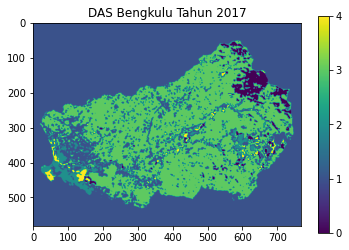

In [ ]:
# Load a new multispectral image
ds, imagas = raster.read('/content/drive/My Drive/dataset/das_bengkulu/2017.tif')
new_features = ml.array_to_chips(imagas, y_size=5, x_size=5)

# Predict new data and export the probability raster
newPredicted = model.predict(new_features/255)
Predicted = np.argmax(newPredicted, axis=-1)
prediction = np.reshape(Predicted, (ds.RasterYSize, ds.RasterXSize))

# Plotting
fig, ax = plt.subplots()
h = ax.imshow(prediction, vmin = 0, vmax = 4)
fig.colorbar(h, ticks = np.linspace(0,4,5))
ax.set_title(f'DAS Bengkulu Tahun 2017')
fig.show()

In [ ]:
# Count the number of pixels 
unique, counts = np.unique(prediction, return_counts=True)
dict(zip(unique, counts))

{0: 15506, 1: 271079, 2: 9359, 3: 146256, 4: 4776}

In [ ]:
#save as.tif
output_file = r'/content/drive/MyDrive/dataset/output/2017.tif'
raster.export(prediction, ds, output_file, dtype='float32')

#### - Prediksi DAS Bengkulu Tahun 2018

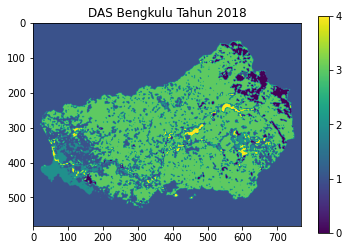

In [ ]:
# Load a new multispectral image
ds, imagas = raster.read('/content/drive/My Drive/dataset/das_bengkulu/2018.tif')
new_features = ml.array_to_chips(imagas, y_size=5, x_size=5)

# Predict new data and export the probability raster
newPredicted = model.predict(new_features/255)
Predicted = np.argmax(newPredicted, axis=-1)
prediction = np.reshape(Predicted, (ds.RasterYSize, ds.RasterXSize))

# Plotting
fig, ax = plt.subplots()
h = ax.imshow(prediction, vmin = 0, vmax = 4)
fig.colorbar(h, ticks = np.linspace(0,4,5))
ax.set_title(f'DAS Bengkulu Tahun 2018')
fig.show()

In [ ]:
# Count the number of pixels 
unique, counts = np.unique(prediction, return_counts=True)
dict(zip(unique, counts))

{0: 15953, 1: 269128, 2: 11707, 3: 144264, 4: 5924}

In [ ]:
#save as.tif
output_file = r'/content/drive/MyDrive/dataset/output/2018.tif'
raster.export(prediction, ds, output_file, dtype='float32')

#### - Prediksi DAS Bengkulu Tahun 2019

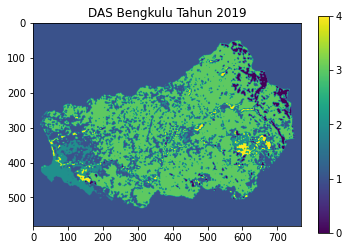

In [ ]:
# Load a new multispectral image
ds, imagas = raster.read('/content/drive/My Drive/dataset/das_bengkulu/2019.tif')
new_features = ml.array_to_chips(imagas, y_size=5, x_size=5)

# Predict new data and export the probability raster
newPredicted = model.predict(new_features/255)
Predicted = np.argmax(newPredicted, axis=-1)
prediction = np.reshape(Predicted, (ds.RasterYSize, ds.RasterXSize))

# Plotting
fig, ax = plt.subplots()
h = ax.imshow(prediction, vmin = 0, vmax = 4)
fig.colorbar(h, ticks = np.linspace(0,4,5))
ax.set_title(f'DAS Bengkulu Tahun 2019')
fig.show()

In [ ]:
# Count the number of pixels 
unique, counts = np.unique(prediction, return_counts=True)
dict(zip(unique, counts))

{0: 12980, 1: 277088, 2: 13916, 3: 136800, 4: 6192}

In [ ]:
#save as.tif
output_file = r'/content/drive/MyDrive/dataset/output/2019.tif'
raster.export(prediction, ds, output_file, dtype='float32')

#### - Prediksi DAS Bengkulu Tahun 2020

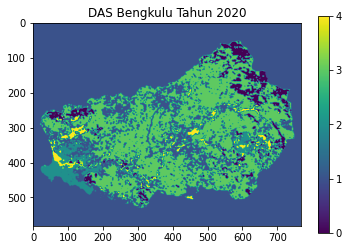

In [ ]:
# Load a new multispectral image
ds, imagas = raster.read('/content/drive/My Drive/dataset/das_bengkulu/2020.tif')
new_features = ml.array_to_chips(imagas, y_size=5, x_size=5)

# Predict new data and export the probability raster
newPredicted = model.predict(new_features/255)
Predicted = np.argmax(newPredicted, axis=-1)
prediction = np.reshape(Predicted, (ds.RasterYSize, ds.RasterXSize))

# Plotting
fig, ax = plt.subplots()
h = ax.imshow(prediction, vmin = 0, vmax = 4)
fig.colorbar(h, ticks = np.linspace(0,4,5))
ax.set_title(f'DAS Bengkulu Tahun 2020')
fig.show()

In [ ]:
# Count the number of pixels 
unique, counts = np.unique(prediction, return_counts=True)
dict(zip(unique, counts))

{0: 22034, 1: 279687, 2: 13897, 3: 123261, 4: 8097}

In [ ]:
#save as.tif
output_file = r'/content/drive/MyDrive/dataset/output/2020.tif'
raster.export(prediction, ds, output_file, dtype='float32')